In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import torch
from mpl_toolkits.mplot3d import Axes3D

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
beta = 0.0921
gamma = 0.0492
tot=1

#def func(s, i,r):
#    ds_t = miu-miu*s-beta*s*i
#    di_t = -miu*i+beta*s*i-gamma*i
#    dr_t = gamma*i-miu*r
#    return ds_t,di_t,dr_t

In [4]:
def boundary(_, on_initial):
    return on_initial

In [5]:
def ode_system(x, y):
    S, I,R = y[:, 0:1], y[:, 1:2], y[:,2:3]
    ds_x = dde.grad.jacobian(y, x, i=0)
    di_x = dde.grad.jacobian(y, x, i=1)
    dr_x = dde.grad.jacobian(y, x, i=2)
    return [ds_x+beta*I*S/tot, di_x-beta*I*S/tot+gamma*I, dr_x-gamma*I,S+I+R-tot]

In [6]:
geom = dde.geometry.TimeDomain(0, 150)
ic1 = dde.icbc.IC(geom, lambda x: 0.968, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0.031667, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0.000333, boundary, component=2)
data = dde.data.PDE(geom, ode_system, [ic1,ic2,ic3], 3000, 100, num_test=100)

layer_size = [1,20,80,256,40,3]
activation = "elu"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
# Most backends except jax can have a second fine tuning of the solution


Compiling model...
'compile' took 0.000220 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.59e-01, 1.78e-01, 1.39e-02, 6.63e+01, 9.37e-01, 1.00e-03, 1.11e-07]    [1.50e-01, 1.68e-01, 1.37e-02, 6.50e+01, 9.37e-01, 1.00e-03, 1.11e-07]    []  
1000      [2.58e-05, 8.20e-06, 1.05e-05, 3.72e-05, 5.02e-08, 3.07e-08, 3.73e-08]    [1.88e-05, 7.45e-06, 8.07e-06, 3.59e-05, 5.01e-08, 3.07e-08, 3.73e-08]    []  
2000      [1.69e-05, 6.41e-06, 7.73e-06, 2.09e-05, 1.67e-08, 6.55e-09, 9.55e-09]    [1.46e-05, 6.45e-06, 7.22e-06, 1.98e-05, 1.67e-08, 6.56e-09, 9.56e-09]    []  
3000      [6.11e-06, 3.96e-06, 2.64e-06, 5.22e-06, 8.13e-09, 2.90e-09, 5.45e-09]    [4.34e-06, 3.80e-06, 2.45e-06, 5.06e-06, 8.13e-09, 2.90e-09, 5.45e-09]    []  
4000      [1.77e-06, 7.74e-07, 3.03e-07, 1.39e-06, 1.60e-09, 7.50e-10, 1.43e-09]    [8.77e-07, 7.43e-07, 2.73e-07

In [32]:
from deepxde.utils.external import *

In [33]:
def pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd
s = pack_data(train_state)

In [34]:
def myplot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure()
        bestval=-1,mxval=-1
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            if i==0:
                plt.plot(X, best_y[idx, i], color='red', label="S")
            elif i==1:
                plt.plot(X, best_y[idx, i], color='green', label="I")
                if best_y[idx, i]>mxval:
                    mxval=best_y[idx, i]
                    bestval=i
            else:
                plt.plot(X, best_y[idx, i], color='blue', label="R")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        print(bestval)
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure()
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))


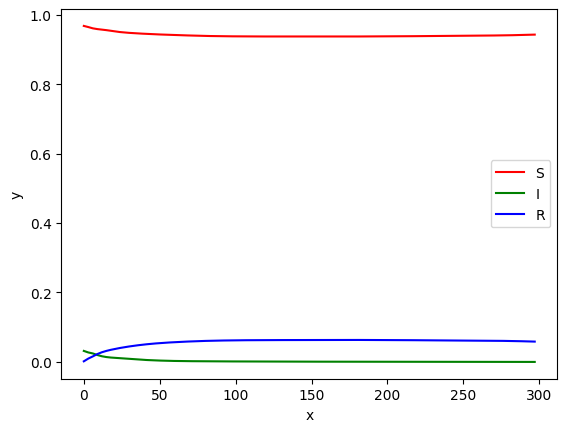

In [35]:
myplot_best_state(train_state)